[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/image_histogram.ipynb)

# Image histogram and equalizations techniques
In this tutorial we are going to learn how using kornia components and Matplotlib we can visualize image histograms and later use kornia functionality to equalize images in batch and using the gpu.

## Install Kornia

In [1]:
%%capture
!pip install kornia

## Prepare the data
The low contrast color image used in this tutorial can be downloaded here (By Biem (Own work) [Public domain], via Wikimedia Commons)

In [2]:
%%capture
!wget https://upload.wikimedia.org/wikipedia/commons/f/fd/Crayfish_low_contrast.JPG
!wget https://upload.wikimedia.org/wikipedia/commons/1/16/Women%27s_Soccer_-_USA_vs_Japan_%281%29.jpg
!wget https://imagemagick.org/image/mountains.jpg
!wget https://p0.piqsels.com/preview/817/405/123/santa-maria-del-mar-la-catedral-del-mar-church-barcelona.jpg

In [3]:
from typing import List, Tuple

from matplotlib import pyplot as plt
import cv2
import numpy as np
import torch
import kornia as K
import torchvision

Image show functionality

In [4]:
def imshow(input: torch.Tensor, height: int, width: int):
    out: torch.Tensor = torchvision.utils.make_grid(input, nrow=2)
    out_np: np.array = K.utils.tensor_to_image(out)
    plt.figure(figsize=(height, width))
    plt.imshow(out_np); plt.axis('off');

Image read functionality

In [5]:
def imread(data_path: str) -> torch.Tensor:
    """Utility function that load an image an convert to torch."""
    # open image using OpenCV (HxWxC)
    img: np.ndarray = cv2.imread(data_path, cv2.IMREAD_COLOR)

    # cast image to torch tensor and convert to RGB
    img_t: torch.Tensor = K.utils.image_to_tensor(img, keepdim=False)  # BxCxHxW
    img_t = img_t.float() / 255.

    img_t = K.color.bgr_to_rgb(img_t)
    img_t = K.geometry.resize(img_t, 1200, side='long', align_corners=True)[..., :600, :]

    return img_t

Image and histogram plot functionality

In [6]:
def histogram_img(img_t: torch.Tensor, size: Tuple[int, int] = (16, 4)):
    CH, H, W = img_t.shape
    img = K.utils.tensor_to_image(img_t.mul(255.).byte())

    plt.figure(figsize=size)
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    colors = ('b','g','r')
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, ec="k")

    for i in range(CH):
        img_vec = img[..., i].flatten()
        ax2.hist(img_vec, range=(0, 255), bins=256, color=colors[i], **kwargs)

    ax1.imshow(img, cmap=(None if CH > 1 else 'gray'))
    ax1.grid(False)
    ax1.axis('off')

    plt.show()

Load the images in batch using OpenCV and show them as a grid.

Image tensor shape: torch.Size([4, 3, 600, 1200])


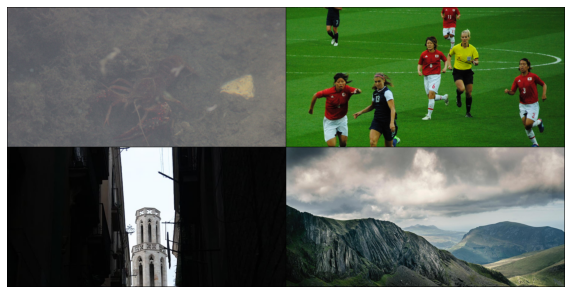

In [7]:
img_rgb_list: List[torch.Tensor] = []
img_rgb_list.append(imread("Crayfish_low_contrast.JPG"))
img_rgb_list.append(imread("Women's_Soccer_-_USA_vs_Japan_(1).jpg"))
img_rgb_list.append(imread("santa-maria-del-mar-la-catedral-del-mar-church-barcelona.jpg"))
img_rgb_list.append(imread("mountains.jpg"))

# cast to torch.Tensor
img_rgb: torch.Tensor = torch.cat(img_rgb_list, dim=0)
print(f"Image tensor shape: {img_rgb.shape}")

# Disable the line below to make everything happen in the GPU !
# img_rbg = img_rbg.cuda()

imshow(img_rgb, 10, 10)  # plot grid !

## Image Histogram

**Definition -** An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image.[1] It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance [Read more - Wikipedia](https://en.wikipedia.org/wiki/Image_histogram).

**In short -** An image histogram is:
- It is a graphical representation of the intensity distribution of an image.
- It quantifies the number of pixels for each intensity value considered.

See also OpenCV tutorial: https://docs.opencv.org/master/d4/d1b/tutorial_histogram_equalization.html



### Lightness with Kornia

We first will compute the histogram of the lightness of the image. To do so, we compute first the color space *Lab* and take the first component known as luminance that reflects the lightness of the scene.

Notice that kornia Lab representation is in the range of [0, 100] and for convenience to plot the histogram we will normalize the image between [0, 1].

**Note:** kornia computes in batch, for convenience we show only one image result. That's it - modify below the `plot_indices` variable to explore the results of the batch.

In [8]:
plot_indices: int = 0  # try: [0, 1, 2, 3]

**Tip:** replace `K.color.rgb_to_lab` by `K.color.rgb_to_grayscale` to see the pixel distribution in the grayscale color space. Explore also `kornia.color` for more exotic color spaces.

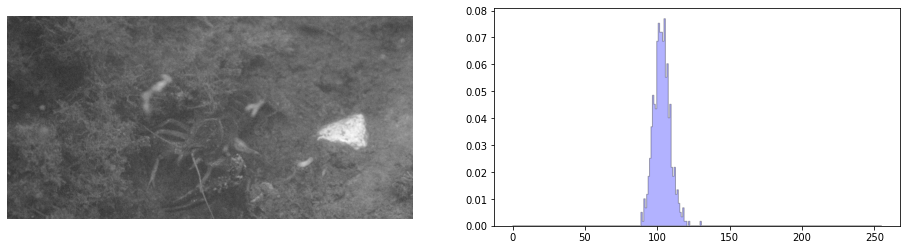

In [9]:
img_lab: torch.Tensor = K.color.rgb_to_lab(img_rgb)
lightness: torch.Tensor = img_lab[..., :1, :, :] / 100. # L in lab is in range [0, 100]

histogram_img(lightness[plot_indices])

### RGB histogram with Kornia

Similar to above - you can just visualize the three (red, green, blue) channels pixel distribution.

**Tip** - Use as follows to visualize a single channel (green)
: `histogram_img(img_rgb[plot_indices, 1:2])`

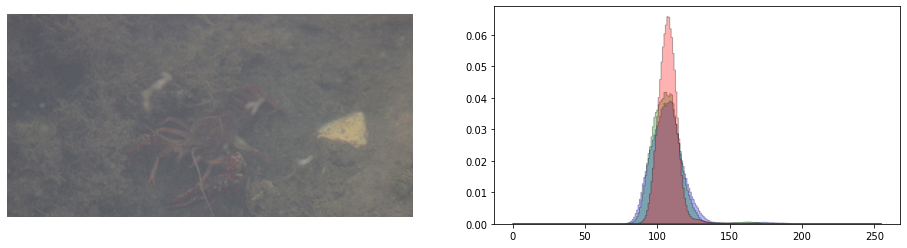

In [10]:
histogram_img(img_rgb[plot_indices])

## Histogram stretching

Sometimes our images have a pixel distribution that is not suitable for our application, being biased to a certain range depending on the illumination of the scene.

In the next sections, we are going to show a couple of techniques to solve those issues. We will start with a basic technique to normalize the image by its minimum and maximum values with the objective to strecth the image histrogram.

### on the lightness with Kornia

We use `kornina.enhance.normalize_min_max` to normalize the image Luminance. Note: compare the histrograms with the original image.

**Tip -** play with the other functions from `kornia.enhance` to modify the intensity values of the image and thus its histograms.

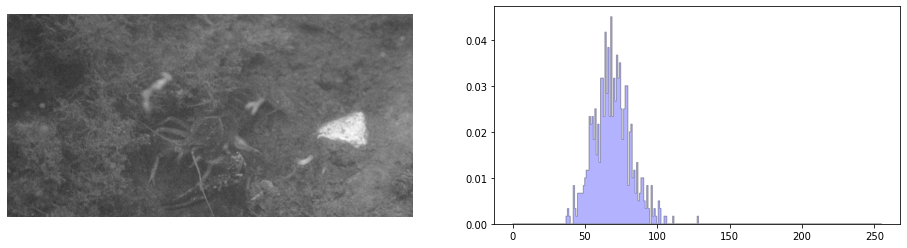

In [11]:
lightness_stretched = K.enhance.normalize_min_max(lightness)
histogram_img(lightness_stretched[plot_indices])

### on the RGB with Kornia

Same as above but compute for all the channels at once.

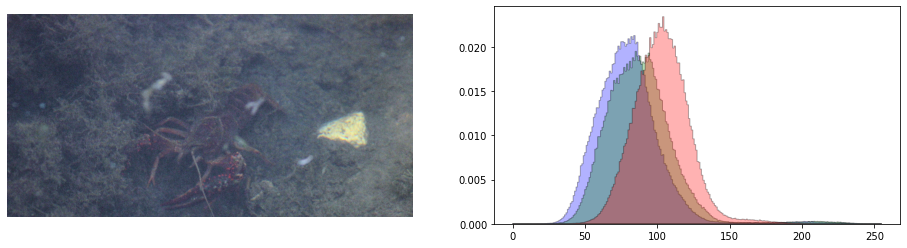

In [12]:
rgb_stretched = K.enhance.normalize_min_max(img_rgb)
histogram_img(rgb_stretched[plot_indices])

## Histogram Equalization

A more advanced technique to improve the pixel distribution is the so called Histogram equalization - a method in image processing of contrast adjustment using the image's histogram [[Read more - Wikipedia]](https://en.wikipedia.org/wiki/Histogram_equalization).

In kornia we have implemented in terms of torch tensor to equalize the images in batch and the gpu very easily.

### on the lightness with Kornia

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


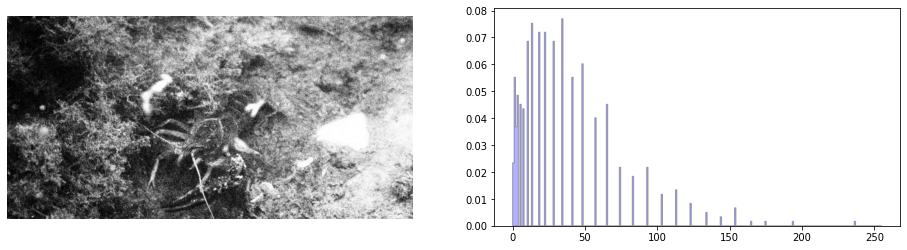

In [13]:
lightness_equalized = K.enhance.equalize(lightness)
histogram_img(lightness_equalized[plot_indices])

### on the RGB with Kornia

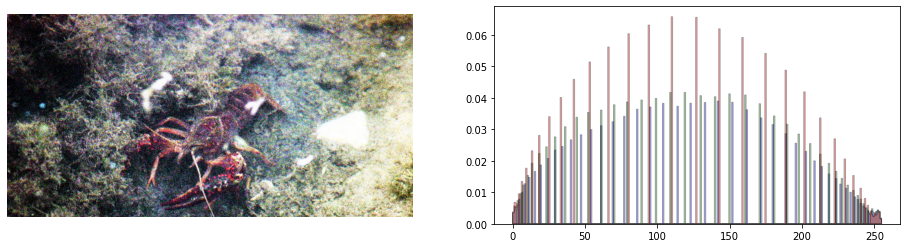

In [14]:
rgb_equalized = K.enhance.equalize(img_rgb)
histogram_img(rgb_equalized[plot_indices])

### on the RGB with OpenCV

Just to compare against OpenCV - close results :)

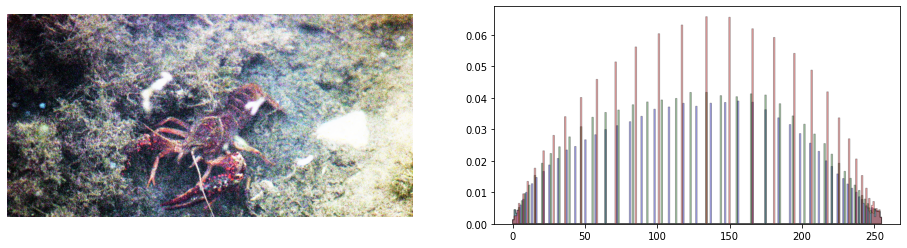

In [15]:
rgb_equalized_cv = []
for img in img_rgb:
    equ00 = torch.tensor(cv2.equalizeHist(K.utils.tensor_to_image(img[0].mul(255).clamp(0, 255).byte())))
    equ01 = torch.tensor(cv2.equalizeHist(K.utils.tensor_to_image(img[1].mul(255).clamp(0, 255).byte())))
    equ02 = torch.tensor(cv2.equalizeHist(K.utils.tensor_to_image(img[2].mul(255).clamp(0, 255).byte())))
    rgb_equalized_cv.append(torch.stack([equ00, equ01, equ02]))
rgb_equalized_cv = torch.stack(rgb_equalized_cv)

histogram_img(rgb_equalized_cv[plot_indices] / 255.)

## Adaptive Histogram Equalization

Adaptive histogram equalization (AHE) is a computer image processing technique used to improve contrast in images. It differs from ordinary histogram equalization in the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the lightness values of the image. It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image [[Read more - Wikipedia]](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization).



### on the lightness with Kornia

We will use `kornia.enhance.equalize_clahe` and by playing with the `clip_limit` and `grid_size` variables to produce different effects to the image.

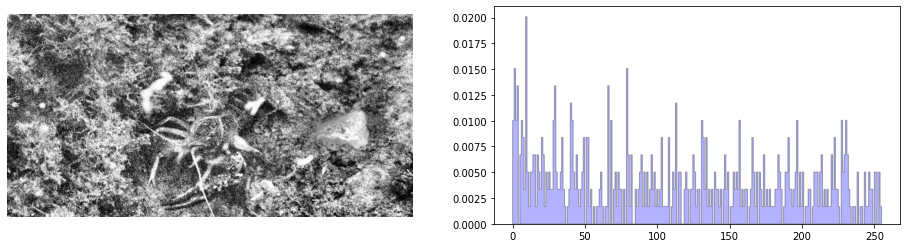

In [16]:
lightness_equalized = K.enhance.equalize_clahe(lightness, clip_limit=0.)
histogram_img(lightness_equalized[plot_indices])

### on the RGB with Kornia

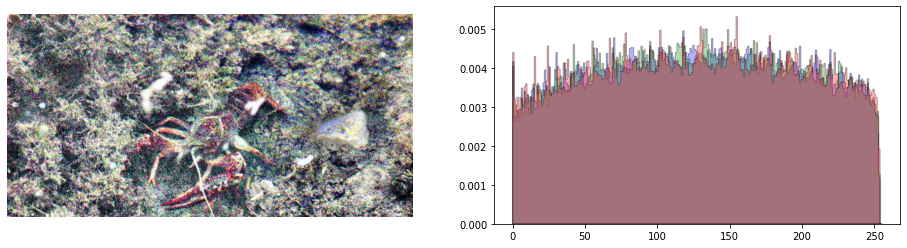

In [17]:
rgb_equalized = K.enhance.equalize_clahe(img_rgb, clip_limit=0.)
histogram_img(rgb_equalized[plot_indices])

## Contrast Limited Adaptive Histogram Equalization (CLAHE)

An improvement of the algorithm is [CLAHE](https://ieeexplore.ieee.org/document/6968381) that divides the image into small blocks and controlled by the variable `grid_size`. This means, that the equalization is performed locally in each of the `NxM` sublocks to obtain a better distribution of the pixel values.


### on the lightness with Kornia

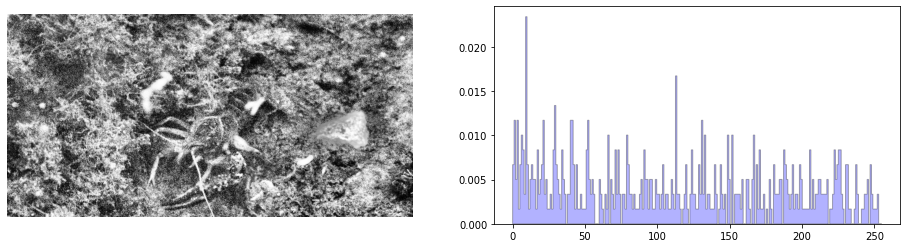

In [18]:
lightness_equalized = K.enhance.equalize_clahe(lightness, clip_limit=20., grid_size=(8,8))
histogram_img(lightness_equalized[plot_indices])

### on the lightness with Opencv

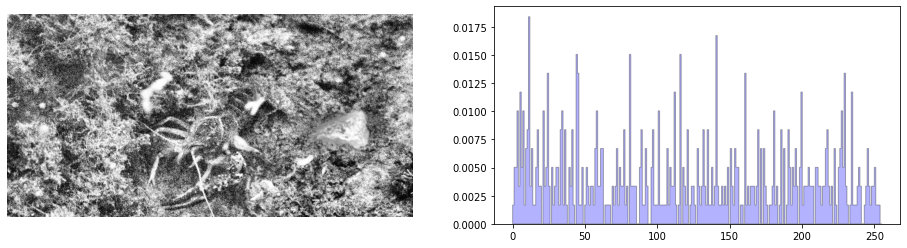

In [19]:
imgs_clahe = []
clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(8, 8))
for im in lightness:
    imgs_clahe.append(torch.tensor(clahe.apply(K.utils.tensor_to_image(im.mul(255).clamp(0, 255).byte()))))
imgs_clahe = torch.stack(imgs_clahe)

histogram_img(imgs_clahe[plot_indices, None] / 255.)

### on the RGB with Kornia

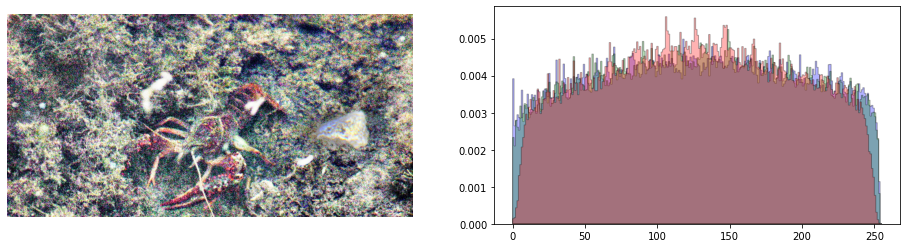

In [20]:
rgb_equalized = K.enhance.equalize_clahe(img_rgb, clip_limit=20., grid_size=(8,8))
histogram_img(rgb_equalized[plot_indices])

### on the RGB with OpenCV

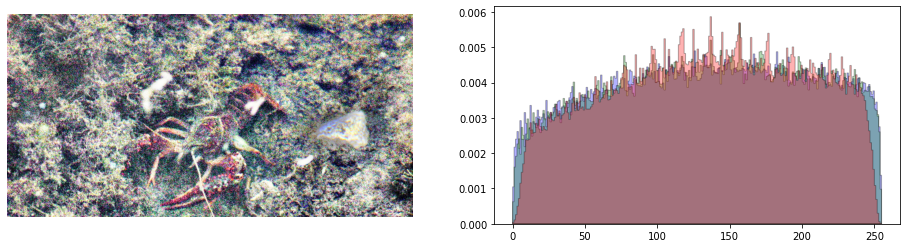

In [21]:
imgs = []
clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(8, 8))
for im in img_rgb:
  # equalize channels independently as gray scale images
  equ00 = torch.tensor(clahe.apply(K.utils.tensor_to_image(im[0].mul(255).clamp(0, 255).byte())))
  equ01 = torch.tensor(clahe.apply(K.utils.tensor_to_image(im[1].mul(255).clamp(0, 255).byte())))
  equ02 = torch.tensor(clahe.apply(K.utils.tensor_to_image(im[2].mul(255).clamp(0, 255).byte())))
  imgs.append(torch.stack([equ00, equ01, equ02]))
imgs = torch.stack(imgs)

histogram_img(imgs[plot_indices] / 255.)